In [86]:
import pandas as pd
import geopandas as gpd
import os
from shapely import geometry
import zipfile
import pickle
from shapely.strtree import STRtree
import shapely.speedups
import shapely.geometry
import shapely.wkt
import matplotlib.pyplot as plt
from pointpats import PointPattern
from datetime import datetime
import numpy as np
from stdbscan import STDBSCAN
from pointpats.centrography import std_distance
import pointpats.quadrat_statistics as qs
import contextily as ctx

plt.rcParams["font.family"] = "Times New Roman"
shapely.speedups.enable()
%matplotlib inline

In [166]:
plt.rcParams["figure.figsize"] = [8.0, 8.0]

In [188]:
# url = 'https://tile.thunderforest.com/landscape/{z}/{x}/{y}.png?apikey=19e9ce8b0fc548e1ad576bb36a1b1750'

def add_basemap(ax, zoom,xmin, xmax, ymin, ymax, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

In [96]:
plt.rcParams["figure.figsize"] = [24.0, 23.0]

In [8]:
# 2263
headers = ["User ID","Venue ID","Venue category ID","Venue category name","Longitude","Latitude","Timezone","UTC time"]
zf = '/Users/GeorgePyne/Downloads/dataset_tsmc2014.zip'
csvs = [i for i in zipfile.ZipFile(zf).namelist() if str(i).endswith('txt')]

with zipfile.ZipFile(zf) as zipf:
    with zipf.open(csvs[0]) as myZip:
        ny = pd.read_csv(myZip, encoding = "ISO-8859-1", names=headers, sep='\t')
        ny["UTC time"] = pd.to_datetime(ny["UTC time"])
        ny = ny.sort_values(by="UTC time")
        ny.index = ny["UTC time"]
        ny = ny.loc['2012-4-3':'2012-4-17']
        ny['geometry'] = [shapely.geometry.Point(lat,lon) for lat,lon in zip(ny.Latitude,ny.Longitude)]
        ny = gpd.GeoDataFrame(ny)
        ny.crs = {'init': 'epsg:4326'}
        ny = ny.to_crs(epsg=2263)
        ny_base = ny['UTC time'][0]
        ny['time'] = ny['UTC time'] - ny_base
        ny['time'] = ny['time'].apply(lambda x: (x.total_seconds() / 120)).astype(int)
        ny["Datetime"] = pd.to_datetime(ny["UTC time"].astype(str).apply(lambda x: x.split('+')[0]))
        ny = ny.drop('UTC time', axis=1).reset_index().drop('UTC time', axis=1)
        
        

        

In [4]:
def extract_moving_cluster_object(data, str_tree):
    results = []
    data['geometry_query'] = [shapely.geometry.Point(lat,lon) for lat,lon in zip(data.Latitude,data.Longitude)]
    for geom,time in zip(data['geometry_query'],data['time']):   
        try:
            result = str_tree[time].query(geom)
            if result:
                results.append(True)
            else:
                results.append(False)
        except:
            results.append(False)
    data['Intersect'] = pd.Series(results).astype(int)
    data = data.drop('geometry_query',axis=1)

    
    return data

In [34]:
ny = extract_moving_cluster_object(ny, mc_test)

In [21]:
def pickle_to_index(filename):
    pickle_dict = {}
    with open(f'{filename}.pickle', 'rb') as handle:
        data = pickle.load(handle)
    for t, g in data.items():
        pickle_dict[t] = STRtree(shapely.wkt.loads(data[t]))
    
    return pickle_dict
    
# sc_test = pickle_to_index('/Users/GeorgePyne/Documents/CASA/Dissertation/IPYNB/decompSpaceTime-master/sc')        
mc = pickle_to_index('/Users/GeorgePyne/Documents/CASA/Dissertation/IPYNB/decompSpaceTime-master/mc')

In [9]:
ny.Latitude,ny.Longitude = ny.geometry.y, ny.geometry.x
ny['geometry_query'] = [shapely.geometry.Point(lat,lon) for lat,lon in zip(ny.Latitude,ny.Longitude)]

In [ ]:
ny = extract_moving_cluster_object(ny, mc_test)

In [ ]:
nnds = []
for t, g in mc_test.items():
    for geom in mc_test[t]._geoms:
        nnds.append(PointPattern(zip(geom.exterior.coords.xy[1],geom.exterior.coords.xy[0])).mean_nnd)
        

In [ ]:
eps1 = (sum(nnds) / len(nnds)) 

In [207]:
35*3

105

In [ ]:
ny = ny.to_crs(epsg=4326)
ny.Latitude,ny.Longitude = ny.geometry.y, ny.geometry.x

In [191]:
st_dbscan = STDBSCAN(col_lat='Latitude', col_lon='Longitude',
                         col_time='Datetime', spatial_threshold=1300,
                         temporal_threshold=7200, min_neighbors=4)
ny_clusters = ny
# ny_clusters.Latitude,ny_clusters.Longitude = ny_clusters.geometry.y, ny_clusters.geometry.x
# ny_clusters = st_dbscan.projection(ny, p1_str='epsg:4326', p2_str='epsg:2263')
ny_clusters = st_dbscan.run(ny_clusters)
ny['cluster_label'] = ny_clusters.cluster

In [192]:
ny_clusters['geometry'] = [shapely.geometry.Point(lat,lon) for lat,lon in zip(ny_clusters.Longitude,ny_clusters.Latitude)]
ny_clusters = gpd.GeoDataFrame(ny_clusters)
ny_clusters.crs = {'init': 'epsg:2263'}
ny_clusters.head(3)

,Longitude,Latitude,Datetime,cluster,geometry
0,9.835345e+05,201522.867732,2012-04-03 18:00:09,-1,POINT (983534.5419340901 201522.8677319883)
1,9.719854e+05,160352.934944,2012-04-03 18:00:25,-1,POINT (971985.4373303206 160352.934943823)
2,1.016665e+06,200215.161983,2012-04-03 18:02:24,-1,POINT (1016664.56146593 200215.1619834262)


In [193]:
ny['cluster_label'] = ny_clusters.cluster

In [ ]:
ny_mo = ny.loc[ny.Intersect == 1]

xmin, ymin, xmax, ymax = ny.total_bounds

for time in ny_mo.time.unique()[0:30]:
    ax = ny_mo.loc[ny_mo.time == time].plot(column='cluster_label', cmap='Set1', legend=True)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    ax.set_title(f'Moving cluster at hour {time}', fontdict={'fontsize': 16, 'fontweight': 'medium'})

In [ ]:
lookup = {} # create dict for key-value lookup
for datetime, hour in zip(ny.Datetime, ny.time):
    if hour in lookup: # Check if STR-tree is drawn for t
        lookup[hour] = lookup[hour]+[datetime]
    else:
        lookup[hour] = [datetime] # Create STR-tree from geometry list



count = 0
directory = '/Users/GeorgePyne/Documents/CASA/Dissertation/IPYNB/decompSpaceTime-master/pointFiles'
length = len(os.listdir(directory))
subdomains = []
noise = -1


for filename in os.listdir(directory): # Iterate over each decomposition domain
    txt = pd.read_csv(directory+'/'+filename, skiprows=1, names=['lon','lat','time']) # read decomp
    txt['datetime'] = txt.time.apply(lambda x: lookup[x][0])
    points = [[lat,lon] for lat,lon in zip(txt.lat, txt.lon)]
    pp = PointPattern(points) # Create point pattern object
    domain_quadrat = qs.QStatistic(pp, shape = "rectangle", nx = 6, ny = 7) # Run quadrat analysis on point pattern object
    pv = float(str(domain_quadrat.chi2_pvalue)[0:4])
    if pv < 1.0: # If not CSR and if statistically significant
        txt['geometry_query'] = [shapely.geometry.Point(point) for point in points]
        txt = extract_moving_cluster_object(txt, mc_test)
        stdd = std_distance(points)
        stdbscan = STDBSCAN(col_lat='lat', col_lon='lon',
                             col_time='datetime', spatial_threshold=stdd,
                             temporal_threshold=7200, min_neighbors=4)
        txt['cluster_label'] = stdbscan.run(txt).cluster 
        subdomains.append(txt)
        n = noise in txt.cluster_label.unique()
        print(f'Noise found = {n}.')
    else:
        print("CSR expected in {}.".format(filename))
    count = count + 1
    print(f'Count at {count} of {length}.\n')

In [ ]:
domain = pd.concat(subdomains)
ny_mo = gpd.GeoDataFrame(domain.loc[domain.Intersect == 1].rename(columns={'geometry_query':'geometry'}))


xmin, ymin, xmax, ymax = ny_mo.total_bounds

for time in ny_mo.time.unique()[0:20]:
    ax = ny_mo.loc[ny_mo.time == time].plot(column='cluster_label', cmap='Set1', legend=True)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    ax.set_title(f'Moving cluster at hour {time}', fontdict={'fontsize': 16, 'fontweight': 'medium'})

In [ ]:
ny_mo.loc[ny_mo.time == time]

In [35]:
from sklearn.neighbors import NearestNeighbors

In [44]:
neigh = NearestNeighbors(n_neighbors=2)

In [188]:
X = np.array([[lon,lat] for lon, lat in zip(ny.Longitude, ny.Latitude)])
X = [[lon, lat, time] for lon, lat, time in zip(ny.Longitude, ny.Latitude, ny.time)]

In [189]:
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

In [170]:
import seaborn as sns
sns.set()

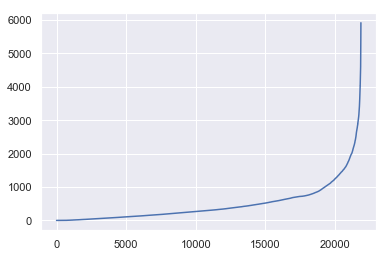

In [190]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances);
# plt.ylim(0,1000)

In [119]:
frame_t,cluster_hull = [],[] 

frames = [ny.loc[ny.time == t] for t in ny.time.unique()]
for frame in frames:
    for i in frame.cluster_label.unique():
        if i > -1:
            if frame.cluster_label.value_counts()[i] > 3:
                geom = frame.loc[frame['cluster_label']==i]
                absortion_condition = PointPattern(zip(geom.Latitude.to_list(), geom.Longitude.to_list())).mean_nnd
                cluster_hull.append\
                (shapely.geometry.MultiPoint(geom.geometry.tolist()).convex_hull.buffer(distance=absortion_condition))
                frame_t.append(frame.time.unique()[0])

In [194]:
ny

,User ID,Venue ID,Venue category ID,Venue category name,Longitude,Latitude,Timezone,geometry,time,Datetime,Intersect,cluster_label,ST_DBSCAN_Intersect,Double_intersect
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,9.835345e+05,201522.867732,-240,POINT (983534.5419340901 201522.8677319883),0,2012-04-03 18:00:09,0,-1,0,0
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,9.719854e+05,160352.934944,-240,POINT (971985.4373303206 160352.934943823),0,2012-04-03 18:00:25,0,-1,0,0
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),1.016665e+06,200215.161983,-240,POINT (1016664.56146593 200215.1619834262),1,2012-04-03 18:02:24,0,-1,0,0
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,9.890939e+05,210760.387122,-240,POINT (989093.9247746313 210760.3871216185),1,2012-04-03 18:02:41,0,1,0,0
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,9.871158e+05,208916.563877,-240,POINT (987115.814715696 208916.5638774919),1,2012-04-03 18:03:00,0,1,0,0
5,484,4b5b981bf964a520900929e3,4bf58dd8d48988d118951735,Food & Drink Shop,9.968163e+05,190820.905713,-240,POINT (996816.2921003118 190820.9057125454),1,2012-04-03 18:04:00,0,-1,0,0
6,642,4ab966c3f964a5203c7f20e3,4bf58dd8d48988d1e0931735,Coffee Shop,9.914201e+05,213102.755525,-240,POINT (991420.0863065931 213102.7555248843),2,2012-04-03 18:04:38,0,1,0,0
7,292,4d0cc47f903d37041864bf55,4bf58dd8d48988d12b951735,Bus Station,9.966183e+05,223244.346826,-240,POINT (996618.2950388758 223244.3468256395),2,2012-04-03 18:04:42,0,2,0,0
8,428,4ce1863bc4f6a35d8bd2db6c,4bf58dd8d48988d103941735,Home (private),9.742870e+05,164851.852354,-240,POINT (974286.9890797726 164851.8523535099),3,2012-04-03 18:06:18,0,-1,0,0
9,877,4be319b321d5a59352311811,4bf58dd8d48988d10a951735,Bank,9.869221e+05,164797.084849,-240,POINT (986922.1463599324 164797.0848485924),3,2012-04-03 18:06:19,0,-1,0,0


In [195]:
ST_DBSCAN_Intersect = []
for i in ny.cluster_label:
    if i == -1:
        ST_DBSCAN_Intersect.append(0)
    else:
        ST_DBSCAN_Intersect.append(1)
    

In [196]:
ny['ST_DBSCAN_Intersect'] = ST_DBSCAN_Intersect

In [132]:
ny_mo = ny.loc[ny.Intersect==1]

In [11]:
xmin, ymin, xmax, ymax = ny.total_bounds

for time in ny_mo.time.unique()[0:30]:
    ax = ny_mo.loc[ny_mo.time == time].plot(column='ST_DBSCAN_Intersect', cmap='Set1', legend=True)
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    ax.set_title(f'Moving cluster at hour {time}', fontdict={'fontsize': 16, 'fontweight': 'medium'})

NameError: name 'ny_mo' is not defined

In [142]:
ny['Double_intersect'] = ny.ST_DBSCAN_Intersect + ny.Intersect

/Users/GeorgePyne/anaconda3/envs/spatiotemporal/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


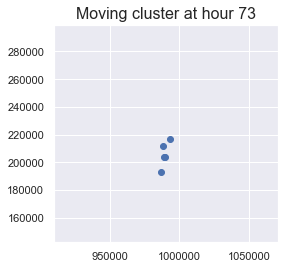

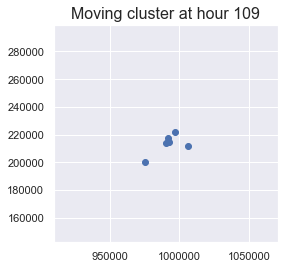

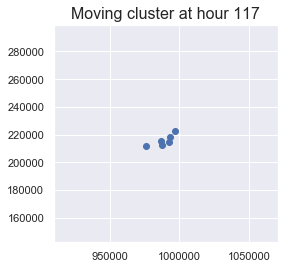

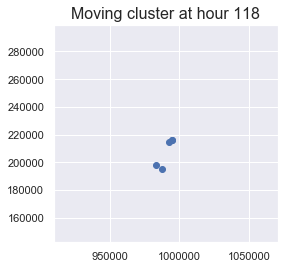

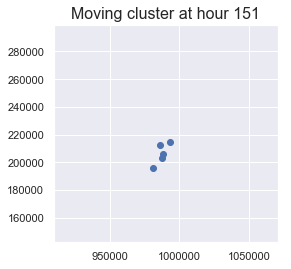

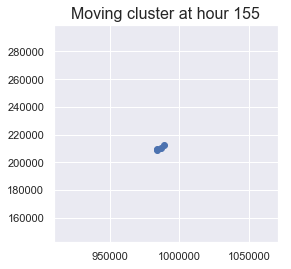

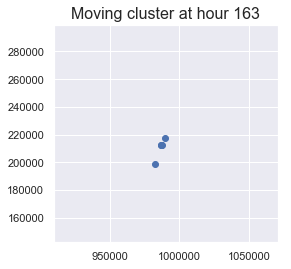

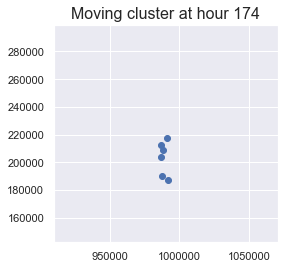

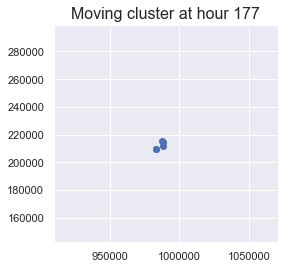

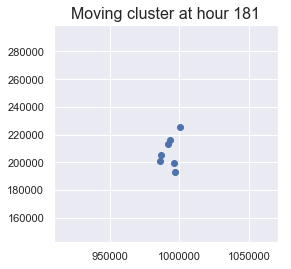

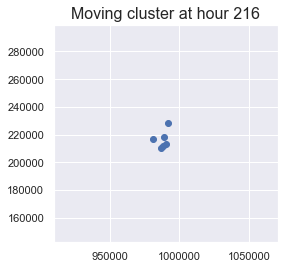

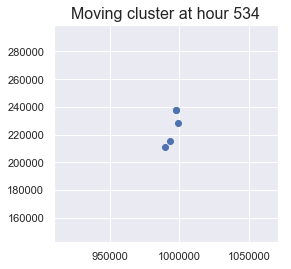

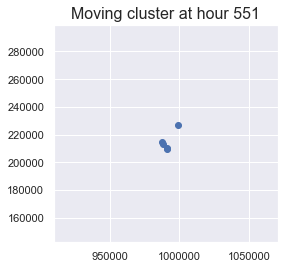

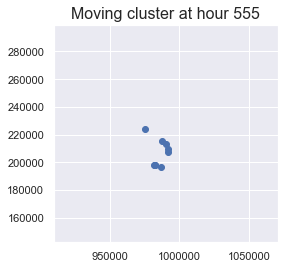

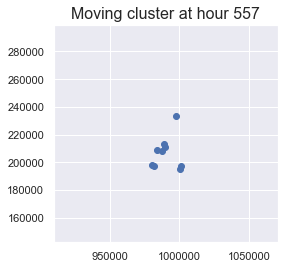

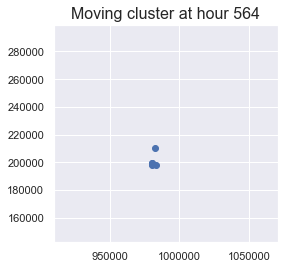

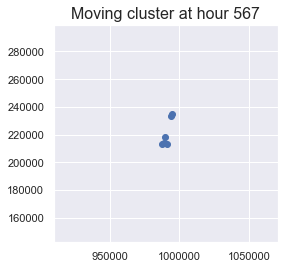

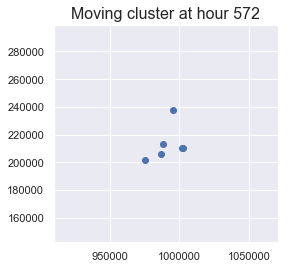

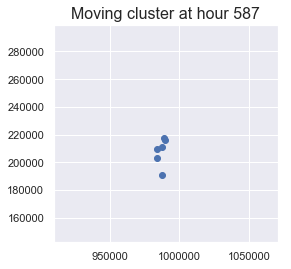

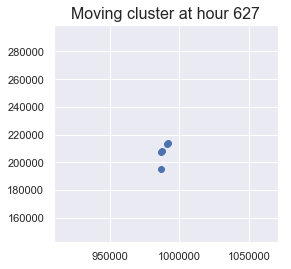

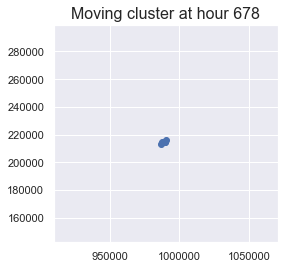

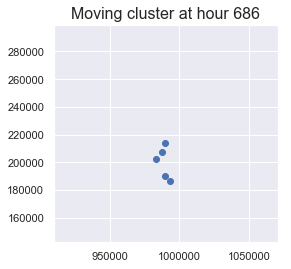

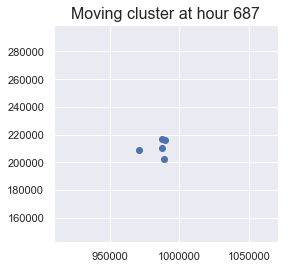

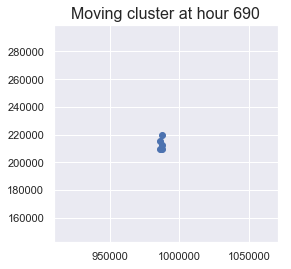

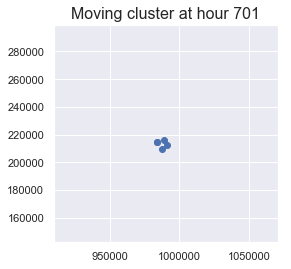

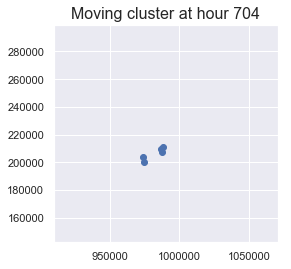

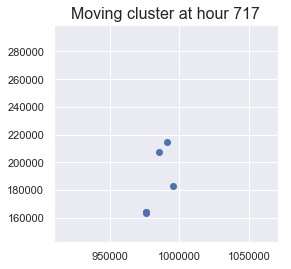

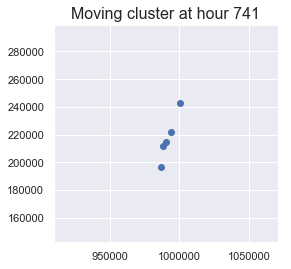

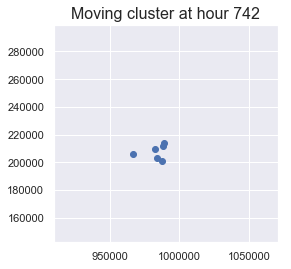

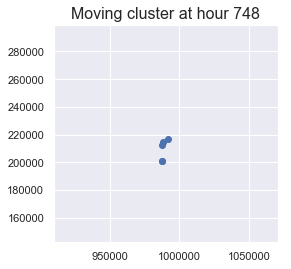

In [147]:
double = ny.loc[ny['Double_intersect']==2]
for time in double.time.unique()[0:30]:
    ax = ny_mo.loc[ny_mo.time == time].plot()
    ax.set_ylim(ymin,ymax)
    ax.set_xlim(xmin,xmax)
    ax.set_title(f'Moving cluster at hour {time}', fontdict={'fontsize': 16, 'fontweight': 'medium'})

In [149]:
ny.Intersect.value_counts()

0    18891
1     2993
Name: Intersect, dtype: int64

In [150]:
ny.ST_DBSCAN_Intersect.value_counts()

0    19226
1     2658
Name: ST_DBSCAN_Intersect, dtype: int64

In [151]:
ny.Double_intersect.value_counts()

0    16884
1     4349
2      651
Name: Double_intersect, dtype: int64

In [211]:
500 

500

In [212]:
lm_times = [4, 3, 3, 7, 6, 3, 3, 5, 6, 4, 5, 9, 10, 8, 8, 5, 2, 3, 4, 1, 2, 7, 8, 3, 7, 2, 3, 5, 6, 2, 8, 5, 8, 3, 1, 4, 5, 2, 9, 2, 9, 8, 6, 2, 2, 2, 7, 3, 5, 4, 5, 9, 4, 6, 9, 2, 2, 4, 2, 2, 6, 9, 2, 4, 4, 3, 3, 2, 4, 7, 2, 5, 3, 6, 7, 8, 10, 9, 3, 2, 6, 7, 6, 6, 5, 9, 1, 2, 2, 6, 5, 8, 12, 2, 4, 5, 8, 7, 9, 8, 7, 3, 4, 4, 1, 6, 8, 2, 3, 4, 5, 2, 4, 1, 3, 5, 5, 4, 2, 4, 6, 5, 2, 9, 6, 7, 4, 5, 4, 4, 10, 1, 4, 7, 5, 5, 8, 5, 5, 6, 14, 4, 1, 2, 7, 4, 11, 9, 13, 11, 7, 9, 4, 5, 9, 2, 7, 9, 8, 8, 10, 9, 8, 2, 9, 6, 7, 14, 9, 8, 6, 5, 5, 7, 5, 7, 4, 7, 2, 7, 8, 7, 6, 1, 2, 6, 4, 4, 9, 12, 3, 5, 3, 8, 4, 5, 5, 2, 8, 4, 6, 2, 6, 3, 6, 3, 6, 8, 5, 5, 9, 6, 1, 5, 4, 1, 8, 7, 5, 1, 5, 2, 4, 2, 2, 7, 6, 3, 7, 2, 3, 3, 8, 5, 8, 4, 6, 6, 3, 4, 2, 8, 9, 8, 8, 3, 1, 2, 5, 5, 3, 4, 5, 4, 9, 2, 5, 4, 3, 3, 9, 1, 9, 5, 4, 3, 5, 3, 9, 5, 5, 7, 4, 3, 3, 7, 2, 4, 2, 5, 8, 6, 7, 3, 4, 7, 4, 3, 6, 2, 5, 3, 2, 3, 9, 5, 5, 1, 9, 6, 9, 6, 9, 1, 4, 9, 7, 3]
grid_times = [3, 1, 1, 4, 3, 1, 1, 3, 3, 1, 2, 4, 4, 4, 4, 3, 1, 1, 2, 0, 1, 4, 4, 2, 5, 1, 1, 2, 2, 1, 3, 3, 3, 1, 0, 2, 3, 1, 5, 1, 5, 4, 3, 1, 0, 1, 3, 1, 2, 2, 2, 4, 2, 3, 4, 1, 1, 2, 1, 1, 3, 5, 1, 1, 2, 2, 1, 1, 2, 3, 1, 3, 1, 2, 4, 4, 5, 4, 1, 1, 3, 3, 3, 3, 2, 5, 0, 1, 1, 3, 2, 4, 6, 1, 2, 4, 5, 4, 4, 5, 4, 1, 1, 1, 0, 3, 5, 1, 1, 2, 2, 1, 2, 0, 1, 3, 2, 2, 1, 1, 3, 2, 1, 4, 2, 4, 2, 2, 2, 2, 5, 0, 2, 3, 2, 3, 5, 2, 2, 2, 6, 2, 0, 1, 4, 2, 5, 5, 7, 7, 4, 4, 2, 2, 5, 1, 3, 5, 5, 4, 5, 5, 5, 2, 5, 3, 3, 7, 10, 3, 3, 2, 3, 3, 2, 3, 2, 3, 1, 4, 4, 4, 3, 1, 1, 3, 2, 2, 5, 8, 1, 2, 1, 6, 2, 3, 2, 1, 4, 1, 3, 1, 3, 1, 3, 1, 2, 4, 2, 3, 5, 3, 0, 2, 2, 1, 4, 3, 2, 0, 3, 1, 2, 1, 1, 3, 2, 1, 3, 1, 1, 1, 5, 3, 4, 2, 3, 3, 1, 2, 1, 4, 4, 4, 4, 1, 0, 1, 2, 2, 1, 2, 2, 2, 5, 1, 2, 2, 2, 1, 5, 1, 5, 3, 1, 1, 2, 1, 4, 2, 2, 3, 2, 1, 1, 3, 1, 2, 1, 3, 4, 3, 4, 2, 2, 3, 2, 2, 3, 1, 2, 1, 1, 1, 4, 2, 2, 1, 5, 2, 5, 3, 5, 0, 1, 4, 3, 1]
ce_times = [23, 39, 41, 182, 150, 1, 1, 110, 99, 1, 13, 126, 147, 7, 49, 6, 1, 0, 4, 0, 1, 1, 57, 1, 93, 1, 4, 5, 7, 1, 35, 111, 99, 4, 0, 2, 68, 0, 203, 1, 229, 144, 52, 0, 1, 1, 129, 14, 7, 60, 87, 175, 103, 84, 161, 0, 2, 6, 4, 1, 82, 185, 0, 1, 11, 8, 9, 4, 6, 136, 0, 142, 3, 5, 189, 47, 129, 18, 0, 0, 69, 32, 117, 91, 1, 189, 0, 1, 0, 15, 2, 110, 150, 0, 2, 15, 206, 123, 154, 141, 173, 2, 1, 4, 0, 91, 230, 1, 2, 72, 24, 3, 61, 0, 4, 95, 109, 102, 1, 4, 20, 2, 1, 162, 53, 202, 126, 135, 76, 45, 229, 0, 36, 40, 6, 75, 220, 18, 22, 7, 138, 1, 0, 1, 112, 2, 173, 63, 202, 171, 113, 57, 13, 1, 135, 0, 202, 189, 104, 77, 308, 19, 1, 0, 16, 36, 108, 292, 159, 7, 1, 0, 14, 127, 130, 54, 74, 99, 0, 173, 172, 211, 99, 1, 1, 123, 17, 39, 274, 276, 2, 79, 0, 179, 17, 78, 129, 1, 167, 4, 49, 1, 18, 1, 18, 1, 7, 150, 136, 35, 233, 107, 0, 6, 8, 1, 178, 148, 5, 0, 72, 0, 6, 1, 1, 62, 6, 2, 129, 1, 3, 1, 215, 111, 147, 75, 162, 118, 9, 70, 1, 106, 120, 74, 191, 2, 0, 1, 8, 29, 1, 55, 39, 55, 240, 3, 6, 8, 12, 2, 211, 0, 202, 44, 4, 2, 81, 1, 195, 12, 24, 135, 41, 1, 0, 126, 1, 14, 1, 86, 63, 77, 179, 7, 8, 52, 51, 3, 157, 0, 108, 1, 4, 9, 191, 98, 5, 0, 274, 6, 229, 148, 228, 0, 2, 195, 157, 5]

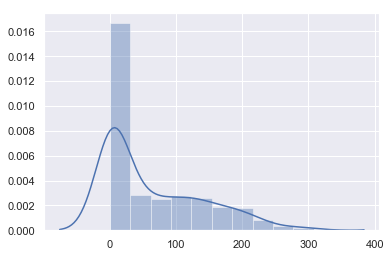

In [218]:
sns.distplot(ce_times)

In [13]:
x_extent = xmax - xmin

In [137]:




for i in [(400/0.3048)]:
    
    eps = x_extent/i
    eps = i
    eps_label = int(eps*0.3048)
    eps_label = 400
    st_dbscan = STDBSCAN(col_lat='Latitude', col_lon='Longitude',
                         col_time='Datetime', spatial_threshold=eps,
                         temporal_threshold=7200, min_neighbors=4)
    ny_clusters = ny
# ny_clusters.Latitude,ny_clusters.Longitude = ny_clusters.geometry.y, ny_clusters.geometry.x
# ny_clusters = st_dbscan.projection(ny, p1_str='epsg:4326', p2_str='epsg:2263')
    ny_clusters = st_dbscan.run(ny_clusters)
    ny[f'cluster_label_{eps_label}'] = (ny_clusters.cluster== -1).astype(int)
    print(f'ST-DBSCAN ran for {i}.')
    
    

ST-DBSCAN ran for 1312.3359580052493.


In [139]:
ny.cluster_label_400.value_counts()

1    13062
0     8822
Name: cluster_label_400, dtype: int64

In [135]:
print(ny[ny.columns[-1]].value_counts()[0])
print(ny[ny.columns[-1]].value_counts()[1])
print(eps_label)

2545
19339
148


In [143]:
ny = extract_moving_cluster_object(ny, mc)

,User ID,Venue ID,Venue category ID,Venue category name,Longitude,Latitude,Timezone,geometry,time,Datetime,...,cluster_label_4109,cluster_label_3793,cluster_label_3522,cluster_label_3287,cluster_label_1896,cluster_label_1174,cluster_label_440,cluster_label_148,cluster_label_400,Intersect
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,9.835345e+05,201522.867732,-240,POINT (983534.5419340901 201522.8677319883),0,2012-04-03 18:00:09,...,0,0,0,0,0,0,1,1,1,0
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,9.719854e+05,160352.934944,-240,POINT (971985.4373303206 160352.934943823),0,2012-04-03 18:00:25,...,0,1,1,1,1,1,1,1,1,0
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),1.016665e+06,200215.161983,-240,POINT (1016664.56146593 200215.1619834262),1,2012-04-03 18:02:24,...,0,0,0,0,1,1,1,1,1,0
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,9.890939e+05,210760.387122,-240,POINT (989093.9247746313 210760.3871216185),1,2012-04-03 18:02:41,...,0,0,0,0,0,0,0,1,0,0
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,9.871158e+05,208916.563877,-240,POINT (987115.814715696 208916.5638774919),1,2012-04-03 18:03:00,...,0,0,0,0,0,0,0,1,0,0
5,484,4b5b981bf964a520900929e3,4bf58dd8d48988d118951735,Food & Drink Shop,9.968163e+05,190820.905713,-240,POINT (996816.2921003118 190820.9057125454),1,2012-04-03 18:04:00,...,0,0,0,0,1,1,1,1,1,0
6,642,4ab966c3f964a5203c7f20e3,4bf58dd8d48988d1e0931735,Coffee Shop,9.914201e+05,213102.755525,-240,POINT (991420.0863065931 213102.7555248843),2,2012-04-03 18:04:38,...,0,0,0,0,0,0,0,1,0,0
7,292,4d0cc47f903d37041864bf55,4bf58dd8d48988d12b951735,Bus Station,9.966183e+05,223244.346826,-240,POINT (996618.2950388758 223244.3468256395),2,2012-04-03 18:04:42,...,0,0,0,0,0,0,0,1,0,0
8,428,4ce1863bc4f6a35d8bd2db6c,4bf58dd8d48988d103941735,Home (private),9.742870e+05,164851.852354,-240,POINT (974286.9890797726 164851.8523535099),3,2012-04-03 18:06:18,...,0,0,1,1,1,1,1,1,1,0
9,877,4be319b321d5a59352311811,4bf58dd8d48988d10a951735,Bank,9.869221e+05,164797.084849,-240,POINT (986922.1463599324 164797.0848485924),3,2012-04-03 18:06:19,...,0,0,0,0,1,1,1,1,1,0


In [249]:
both = ny[(ny['cluster_label_148'] == 0) &  (ny['Intersect'] == 1)]
mc_clust = ny[(ny['cluster_label_148'] == 1) &  (ny['Intersect'] == 1)]
st_clust = ny[(ny['cluster_label_148'] == 0) &  (ny['Intersect'] == 0)]
noise = ny[(ny['cluster_label_148'] == 1) &  (ny['Intersect'] == 0)]

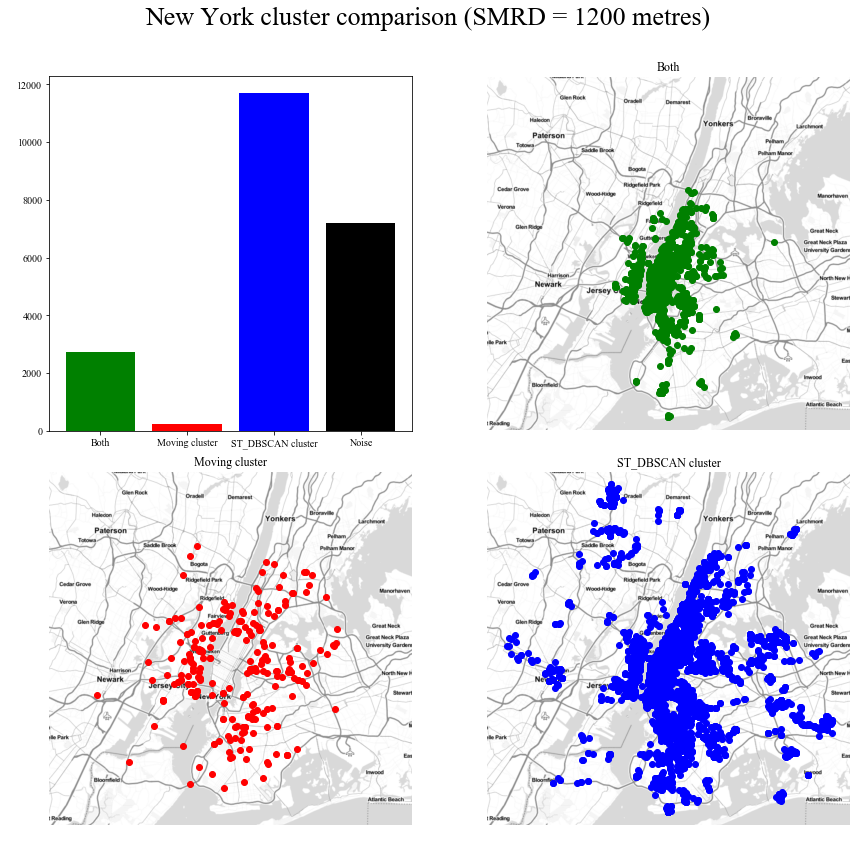

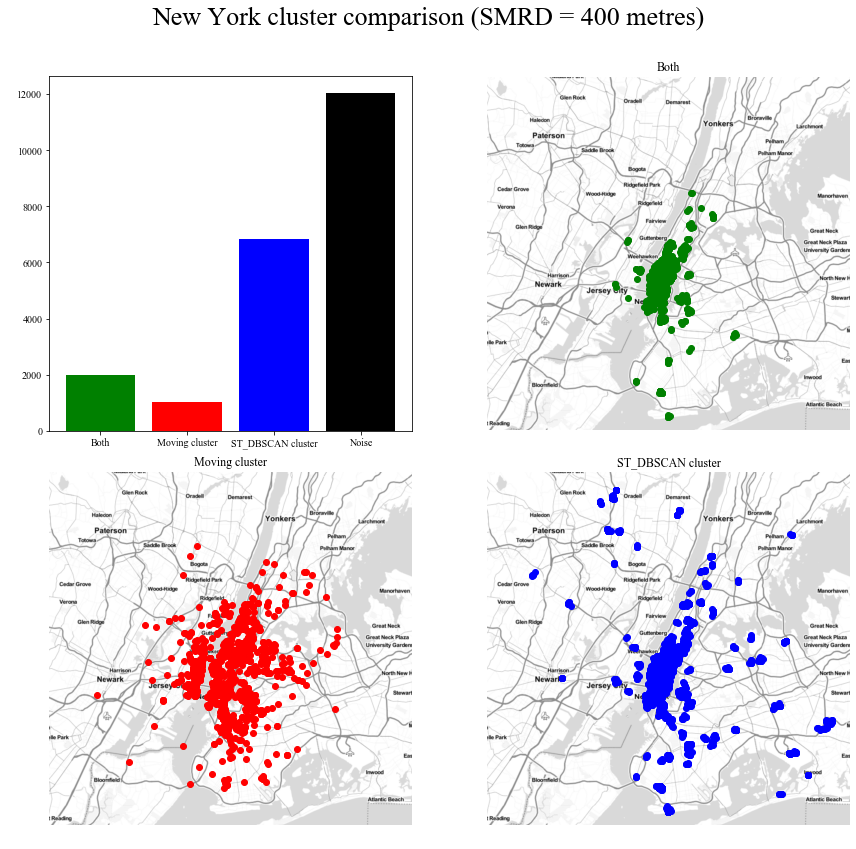

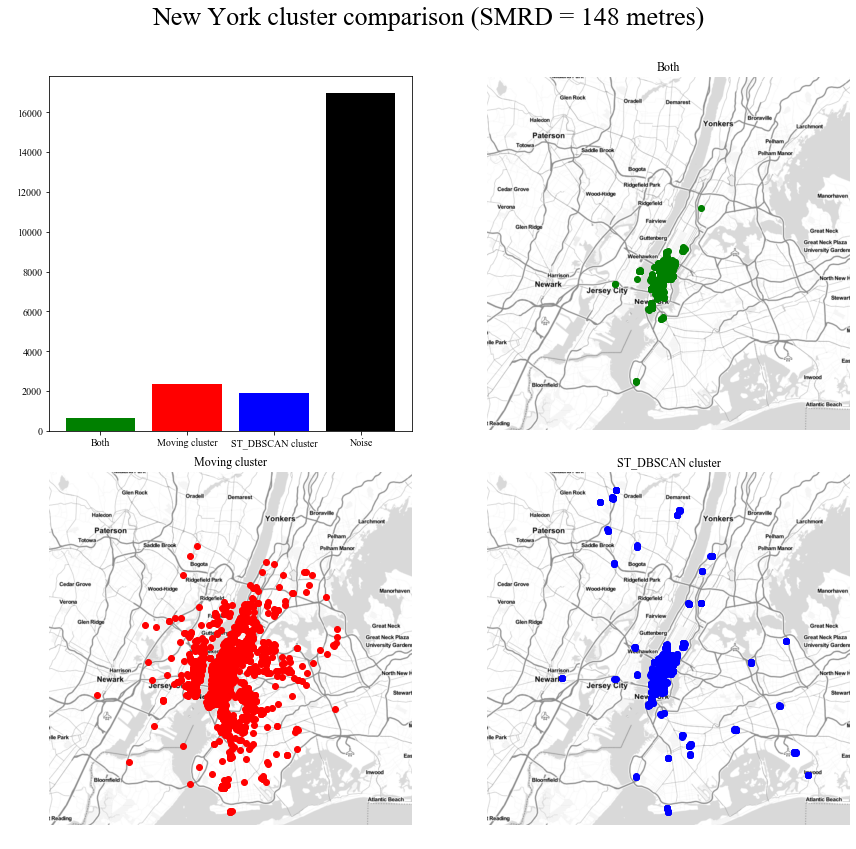

In [258]:
replace = {1174:1200,400:400,148:148}

for i in [1174,400,148]:
    both = ny[(ny[f'cluster_label_{i}'] == 0) &  (ny['Intersect'] == 1)]
    mc_clust = ny[(ny[f'cluster_label_{i}'] == 1) &  (ny['Intersect'] == 1)]
    st_clust = ny[(ny[f'cluster_label_{i}'] == 0) &  (ny['Intersect'] == 0)]
    noise = ny[(ny[f'cluster_label_{i}'] == 1) &  (ny['Intersect'] == 0)]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.0, 12.0))

    # Bar Graph
    objects = ('Both', 'Moving cluster', 'ST_DBSCAN cluster', 'Noise')
    labels = ['Both', 'Moving cluster', 'ST_DBSCAN cluster', 'Noise']
    y_pos = np.arange(len(objects))
    performance = [len(i) for i in [both,mc_clust,st_clust,noise]]

    ax1 = ax1.bar(y_pos, performance, align='center',color=['green','red','blue','black'],tick_label=labels)


    xmin, ymin, xmax, ymax = ny.to_crs(epsg=3857).total_bounds


    wm = both.to_crs(epsg=3857)
    ax2 = wm.plot(color='green', ax=ax2)
    add_basemap(ax=ax2,zoom=11,xmin=xmin,ymin=ymin,xmax=xmax,ymax=ymax,url=ctx.sources.ST_TONER_LITE)
    ax2.set_title(labels[0])
    ax2.set_axis_off()

    wm = mc_clust.to_crs(epsg=3857)
    ax3 = wm.plot(color='red', ax=ax3)
    add_basemap(ax=ax3,zoom=11,xmin=xmin,ymin=ymin,xmax=xmax,ymax=ymax,url=ctx.sources.ST_TONER_LITE)
    ax3.set_title(labels[1])
    ax3.set_axis_off()

    wm = st_clust.to_crs(epsg=3857)
    ax4 = wm.plot(color='blue', ax=ax4)
    add_basemap(ax=ax4,zoom=11,xmin=xmin,ymin=ymin,xmax=xmax,ymax=ymax,url=ctx.sources.ST_TONER_LITE)
    ax4.set_title(labels[2])
    ax4.set_axis_off()

    plt.tight_layout(w_pad=3)
    plt.subplots_adjust(top=0.90)
    fig.suptitle(f'New York cluster comparison (SMRD = {replace[i]} metres)', size=26, verticalalignment='top');
    plt.savefig(f'cluster_map_{replace[i]}_test.png',dpi=150)




In [182]:
noise.plot()

In [201]:
plt.bar?

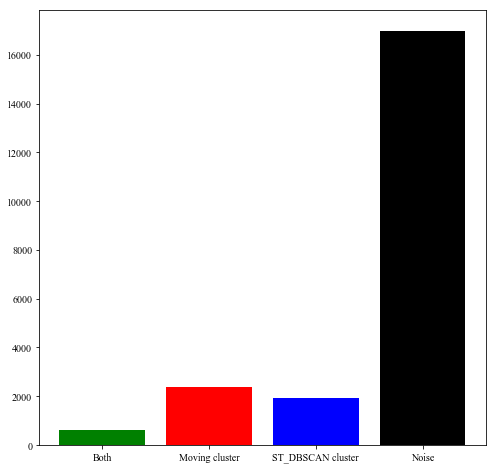

In [205]:
objects = ('Both', 'Moving cluster', 'ST_DBSCAN cluster', 'Noise')
y_pos = np.arange(len(objects))
performance = [len(i) for i in [both,mc_clust,st_clust,noise]]

plt.bar(y_pos, performance, align='center',color=['green','red','blue','black'])
plt.xticks(y_pos, objects);

In [151]:
print('At ST-DBSCAN eps 148m')
st_clusts = [ny.cluster_label_148.value_counts()[0]]


At ST-DBSCAN eps 148m


2545

In [145]:
ny.Intersect.unique()

array([0, 1])

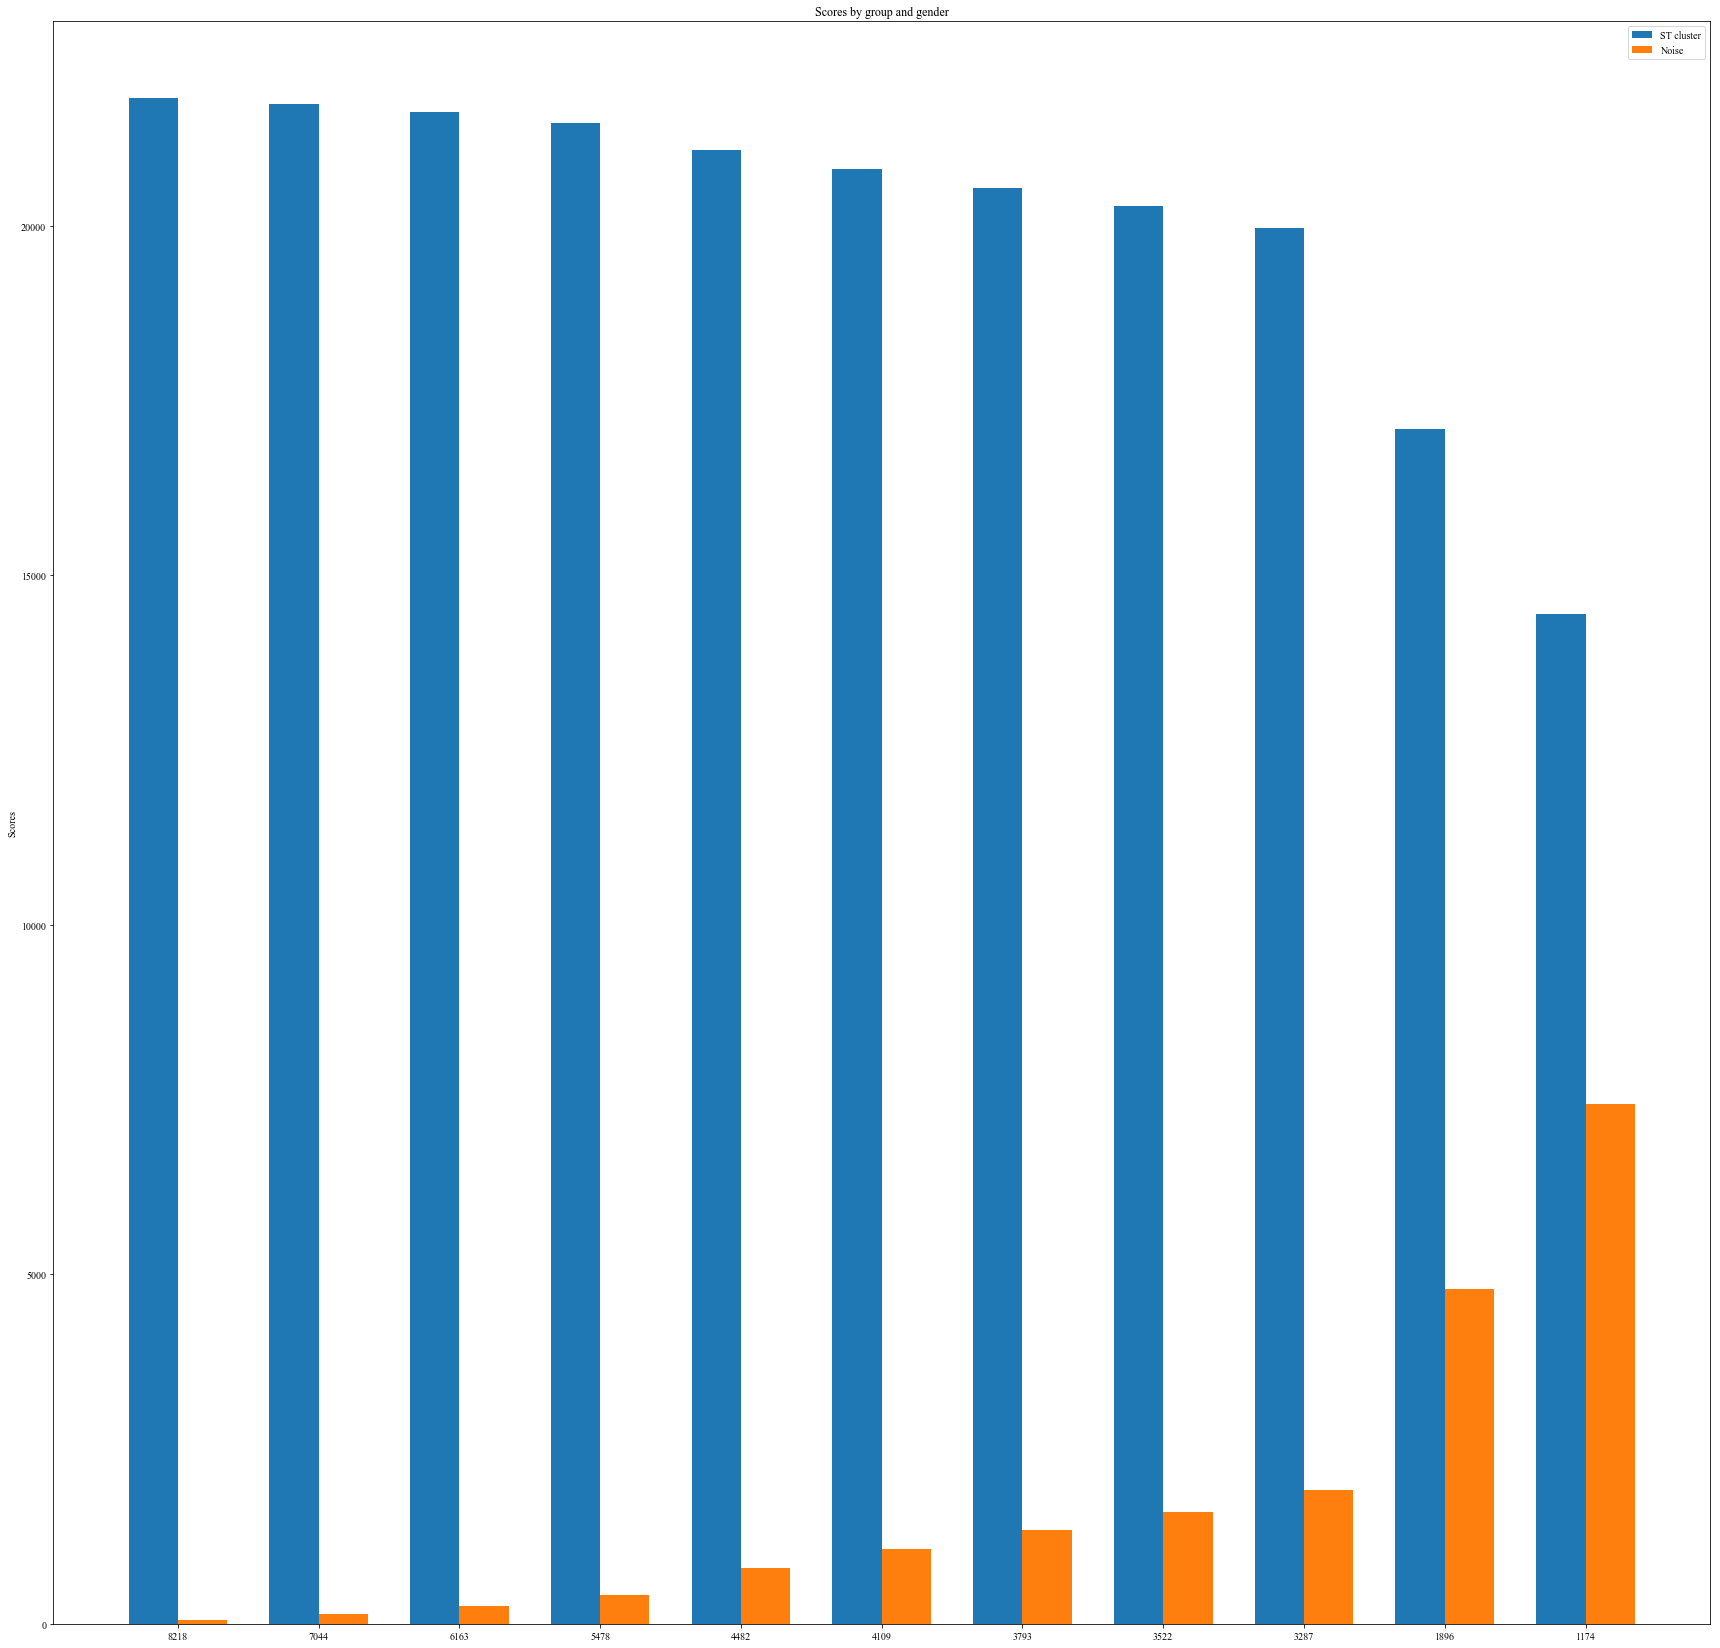

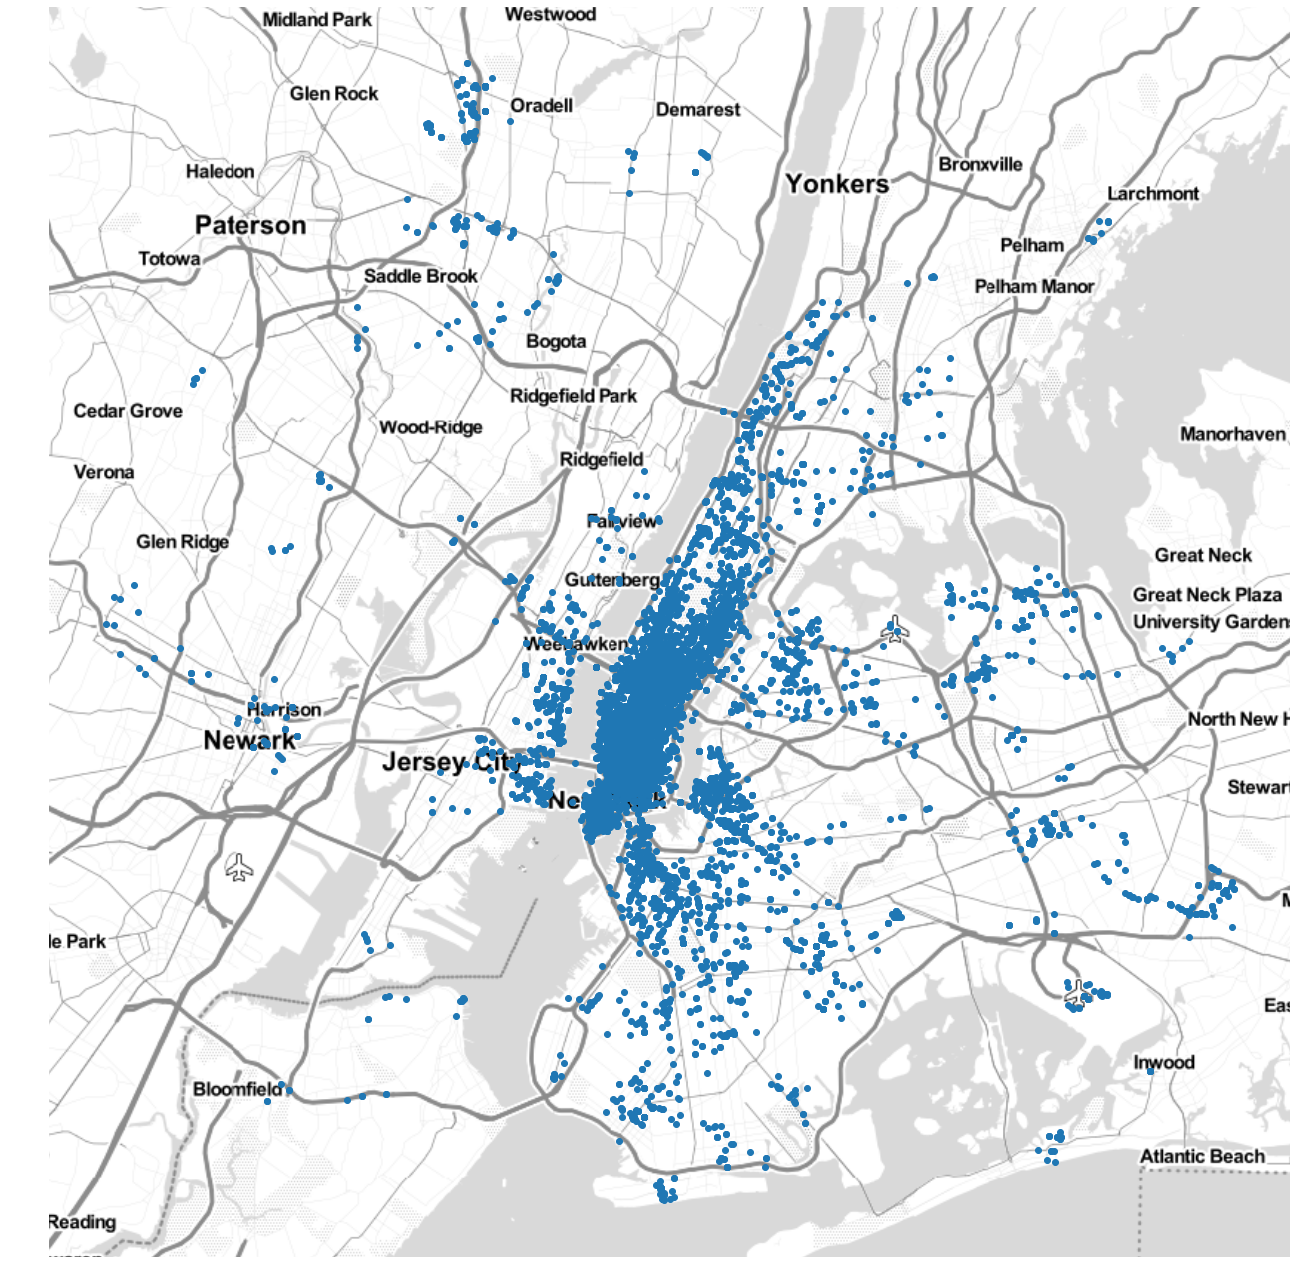

In [130]:
labels = N+[]
clust = [21833,21747,21626,21476,21079,20818,20546,20281,19976,17089,14448]
noise = [51,137,258,408,805,1066,1338,1603,1908,4795,7436]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, clust, width, label='ST cluster')
rects2 = ax.bar(x + width/2, noise, width, label='Noise')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


# def autolabel(rects):
#     """Attach a text label above each bar in *rects*, displaying its height."""
#     for rect in rects:
#         height = rect.get_height()
#         ax.annotate('{}'.format(height),
#                     xy=(rect.get_x() + rect.get_width() / 2, height),
#                     xytext=(0, 3),  # 3 points vertical offset
#                     textcoords="offset points",
#                     ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)




fig.tight_layout()

plt.show()


wm = ny.to_crs(epsg=3857)
ax2 = wm.loc[wm.cluster_label_1174 == 0].plot()
add_basemap(ax2, zoom=11, url=ctx.sources.ST_TONER_LITE)
ax2.set_axis_off()

In [102]:
len(wm.loc[wm.cluster_label_7044 == 1])

137

In [91]:
ny.cluster_label_7044.value_counts()

0    21747
1      137
Name: cluster_label_7044, dtype: int64

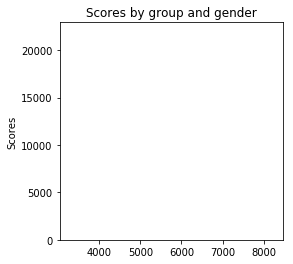

In [71]:

st_clusts = ()

width = 0.35  

st_noise = ()

eps = np.array(N) 

plt.bar(eps, st_clusts, width, label='Men')
plt.bar(eps + width, women_means, width,
    label='Women')

plt.ylabel('Scores')
plt.title('Scores by group and gender')


plt.show()

In [42]:
ind

array([8218, 7044, 6163, 5478, 4482, 4109, 3793, 3522, 3287])

21476

In [62]:
len(N)

9

In [107]:
N = []
for i in ny.columns[13:]:
    N.append(int(i.split('_')[-1]))
    print(ny[i].value_counts()[1])
    


51
137
258
408
805
1066
1338
1603
1908
4795


In [238]:
ny_mo = ny.loc[ny.Intersect==1]

In [239]:
data_lengths = []
for i in range(10,16):
    data_lengths.append(len(ny_mo.loc[ny_mo[f'cluster_label_{i}']>-1]))
    

In [241]:
data_lengths

[2993, 2991, 2991, 2990, 2990, 2986]

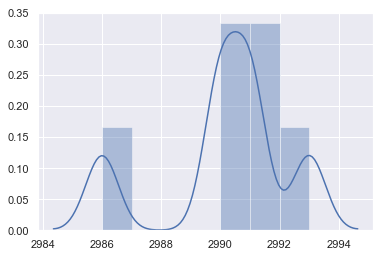

In [240]:
sns.distplot(data_lengths)

In [236]:
len(ny_mo)

2993